# Monstrinho 3.5 
## Forma, função e ativação
####  Rômulo Emanuel Rabelo Cruz 24024

### Enunciado:

**Objetivo:** implemente 3 novas funções de ativação na rede neural feita em Python
puro nos vídeos da disciplina. Escreva brevemente sobre estas 3 funções de ativação,
mostrando a equação delas e comentando a diferença com relação à função de ativação
sigmoidal. Mostre que seu código funciona rodando alguns testes simples.

**Comentário:** aqui não é o lugar de inventar funções de ativação. Busque por funções
de ativação já existentes utilizadas em redes neurais.

**Comentário 2:** observe que o enunciado diz claramente que é para realizar a tarefa
na rede neural feita em Python puro nos vídeos da disciplina. Se você está usando o
PyTorch, numpy, tensorflow, keras, lightning ou qualquer outra biblioteca pronta,
você está no caminho errado!

### Introdução:
As funções de ativação desempenham um papel crucial em redes neurais, adicionar não linearidade, ou seja, sem elas temos apenas uma combinação de linear pesos e viéses. Cada função possui características específicas que a tornam mais adequada para determinados problemas. Por exemplo:

- **tanh**: Normaliza os valores de saída entre -1 e 1, sendo útil para dados centrados em torno de zero.
- **ReLU**: Introduz não linearidade de forma simples e eficiente, sendo amplamente utilizada em redes profundas devido à sua simplicidade computacional.
- **Softplus**: Uma alternativa suave à ReLU, que evita o problema de gradientes nulos para valores negativos.

### Imports Necessários:

In [50]:
import math
import matplotlib.pyplot as plt

#### Classes da Rede Neural  em python puro:

In [51]:
from graphviz import Digraph


def _tracar(folha):
    """Função modificada da criada por Andrej Karpathy para construção de grafo.

    Referência: https://github.com/karpathy/micrograd

    """
    vertices = set()
    arestas = set()

    def construir(v):
        """Função recursiva para traçar o grafo."""
        if v not in vertices:
            vertices.add(v)
            for progenitor in v.progenitor:
                arestas.add((progenitor, v))
                construir(progenitor)

    construir(folha)

    return vertices, arestas


def plota_grafo(folha):
    """Função modificada da criada por Andrej Karpathy para construção de grafo.

    Referência: https://github.com/karpathy/micrograd

    """
    grafo = Digraph(format="svg", graph_attr={"rankdir": "LR"})
    vertices, arestas = _tracar(folha)

    for v in vertices:
        id_vertice = str(id(v))

        if hasattr(v, "rotulo") and (hasattr(v, "grad")):
            texto = "{ " + f"{v.rotulo} | data {v.data:.3f} | grad {v.grad:.3f}" + " }"

        elif hasattr(v, "rotulo"):
            texto = "{ " + f"{v.rotulo} | data {v.data:.3f}" + " }"

        else:
            texto = "{ " + f"data {v.data:.3f}" + " }"

        grafo.node(name=id_vertice, label=texto, shape="record")

        if v.operador_mae:
            grafo.node(name=id_vertice + v.operador_mae, label=v.operador_mae)
            grafo.edge(id_vertice + v.operador_mae, id_vertice)

    for vertice1, vertice2 in arestas:
        grafo.edge(str(id(vertice1)), str(id(vertice2)) + vertice2.operador_mae)

    return grafo

In [52]:
class Valor:
    def __init__(self, data, progenitor=(), operador_mae="", rotulo=""):
        self.data = data
        self.progenitor = progenitor
        self.operador_mae = operador_mae
        self.rotulo = rotulo
        self.grad = 0

    def __repr__(self):
        return f"Valor(data={self.data})"
    
    def __add__(self, outro_valor):
        """Realiza a operação: self + outro_valor."""
        
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
            
        progenitor = (self, outro_valor)
        data = self.data + outro_valor.data
        operador_mae = "+"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_adicao():
            self.grad += resultado.grad
            outro_valor.grad += resultado.grad
            
        resultado.propagar = propagar_adicao
        
        return resultado
    
    def __mul__(self, outro_valor):
        """Realiza a operação: self * outro_valor."""
        
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
            
        progenitor = (self, outro_valor)
        data = self.data * outro_valor.data
        operador_mae = "*"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_multiplicacao():
            self.grad += resultado.grad * outro_valor.data # grad_filho * derivada filho em relação a mãe
            outro_valor.grad += resultado.grad * self.data
            
        resultado.propagar = propagar_multiplicacao
        
        return resultado
    
    def exp(self):
        """Realiza a operação: exp(self)"""
        progenitor = (self, )
        data = math.exp(self.data)
        operador_mae = "exp"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_exp():
            self.grad += resultado.grad * data 
        
        resultado.propagar = propagar_exp
        
        return resultado
    
    
    def __pow__(self, expoente):
        """Realiza a operação: self ** expoente"""
        assert isinstance(expoente, (int, float))
        progenitor = (self, )
        data = self.data ** expoente
        operador_mae = f"**{expoente}"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_pow():
            self.grad += resultado.grad * (expoente * self.data ** (expoente - 1))
        resultado.propagar = propagar_pow
        return resultado
    
    def __truediv__(self, outro_valor):
        """Realiza a operação: self / outro_valor"""
        return self * outro_valor ** (-1)
    
    def __neg__(self):
        """Realiza a operação: -self"""
        return self * -1
    
    def __sub__(self, outro_valor):
        """Realiza a operação: self - outro_valor"""
        return self + (-outro_valor)
    
    def __radd__(self, outro_valor):
        """Realiza a operação: outro_valor + self"""
        return self + outro_valor
    
    def __rmul__(self, outro_valor):
        """Realiza a operação: outro_valor * self"""
        return self * outro_valor
    
    def sig(self):
        """Realiza a operação: exp(self) / (exp(self) + 1)"""
        return self.exp() / (self.exp() + 1)
    
    def propagar(self):
        pass
    
    def propagar_tudo(self):
        
        self.grad = 1
        
        ordem_topologica = []
        
        visitados = set()

        def constroi_ordem_topologica(v):
            if v not in visitados:
                visitados.add(v)
                for progenitor in v.progenitor:
                    constroi_ordem_topologica(progenitor)
                ordem_topologica.append(v)

        constroi_ordem_topologica(self)
        
        for vertice in reversed(ordem_topologica):
            vertice.propagar()
        

Vamos adicionar um método log para retornar o logarítmo natural de um número para usar-lo nas funções de ativação:

In [53]:
def log(self):
    """Calcula o logaritmo natural do número"""
    progenitor = (self,)
    data = math.log(self.data)
    resultado = Valor(data, progenitor, "log")

    def propagar_log():
        self.grad += resultado.grad * (1 / self.data)

    resultado.propagar = propagar_log
    return resultado
Valor.log = log

Vamos adicionar então a função de tangente hiperólica, a tanh:

$$\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$$

In [54]:
def tanh(self):
        """Realiza a operação: exp(self) - exp(-self) / (exp(self) + exp(-self))"""
        temp = -self # Variável temporária igual a -x
        return (self.exp() - temp.exp()) / (self.exp() + temp.exp())
Valor.tanh = tanh

Vamos adicionar também a função ReLU:
$$
\text{ReLU}(x) = 
\begin{cases}
x, & \text{se } x > 0 \\
0, & \text{se } x \leq 0
\end{cases}
$$

In [55]:
def ReLU(self):
    """Retorna self se x>0 e 0 se x<=0"""
    if self.data > 0:
        resultado = Valor(self.data, (self,), "ReLU")
    else:
        resultado = Valor(0, (self,), "ReLU")
    def propagar_relu():
        self.grad += resultado.grad * (1 if self.data > 0 else 0)
    resultado.propagar = propagar_relu
    return resultado
Valor.ReLU = ReLU

Vamos adicionar por fim a função Softplus:
$$\text{Softplus}(x) = \log(1 + e^x)$$

In [56]:
def Softplus(self):
    """Realiza a operação: log(1 + (self))"""
    temp = 1 + self.exp()
    return temp.log()
Valor.Softplus = Softplus

Testando a função tanh:

Os valores devem dar:

In [57]:
tanh_valores = [math.tanh(i * 0.5) for i in range(-10, 11)]
print(tanh_valores)

[-0.9999092042625951, -0.9997532108480275, -0.999329299739067, -0.9981778976111987, -0.9950547536867305, -0.9866142981514303, -0.9640275800758169, -0.9051482536448664, -0.7615941559557649, -0.46211715726000974, 0.0, 0.46211715726000974, 0.7615941559557649, 0.9051482536448664, 0.9640275800758169, 0.9866142981514303, 0.9950547536867305, 0.9981778976111987, 0.999329299739067, 0.9997532108480275, 0.9999092042625951]


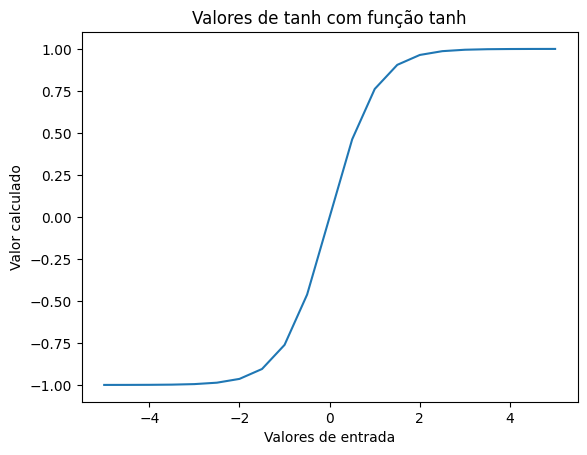

In [58]:
eixo = [i * 0.5 for i in range(-10,11)]
plt.plot(eixo, tanh_valores, label='Diferença do valores obtidos em diferentes métodos')
plt.xlabel('Valores de entrada')
plt.ylabel('Valor calculado')
plt.title('Valores de tanh com função tanh')
plt.show()

Agora, usando o método de valor:

In [59]:
tanh_method_valores = [Valor(i * 0.5).tanh().data for i in range(-10, 11)]
print(tanh_method_valores)

[-0.999909204262595, -0.9997532108480275, -0.9993292997390668, -0.9981778976111987, -0.9950547536867305, -0.9866142981514303, -0.964027580075817, -0.9051482536448664, -0.761594155955765, -0.46211715726000985, 0.0, 0.46211715726000985, 0.761594155955765, 0.9051482536448664, 0.964027580075817, 0.9866142981514303, 0.9950547536867305, 0.9981778976111987, 0.9993292997390668, 0.9997532108480275, 0.999909204262595]


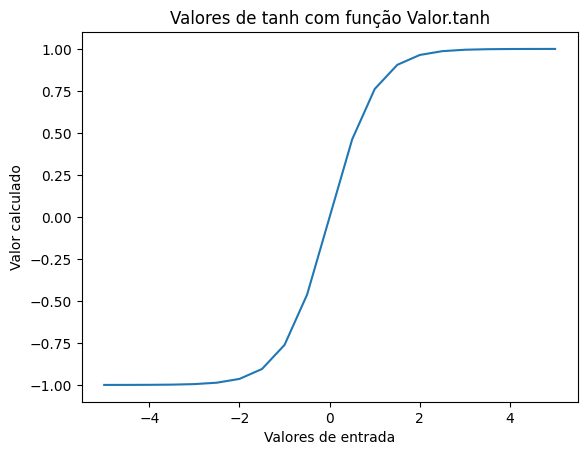

In [60]:
eixo = [i * 0.5 for i in range(-10,11)]
plt.plot(eixo, tanh_method_valores, label='Diferença do valores obtidos em diferentes métodos')
plt.xlabel('Valores de entrada')
plt.ylabel('Valor calculado')
plt.title('Valores de tanh com função Valor.tanh')
plt.show()

Testando a função ReLU:

In [61]:

RELU_valores = [((i * 0.5) > 0) * i*0.5  for i in range(-10, 11)]

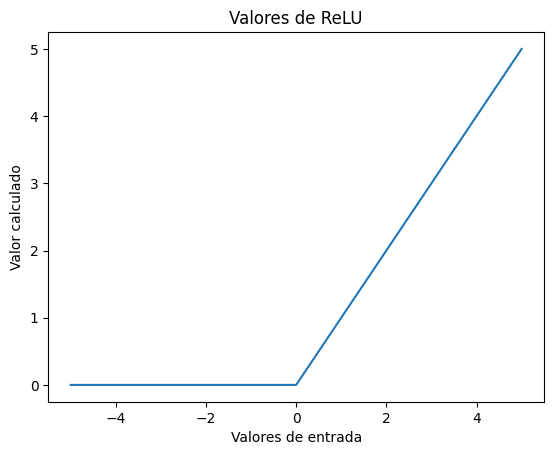

In [62]:
eixo = [i * 0.5 for i in range(-10,11)]
plt.plot(eixo, RELU_valores, label='Diferença do valores obtidos em diferentes métodos')
plt.xlabel('Valores de entrada')
plt.ylabel('Valor calculado')
plt.title('Valores de ReLU')
plt.show()

In [63]:
RELU_valores_method = [Valor(i * 0.5).ReLU().data for i in range(-10, 11)]

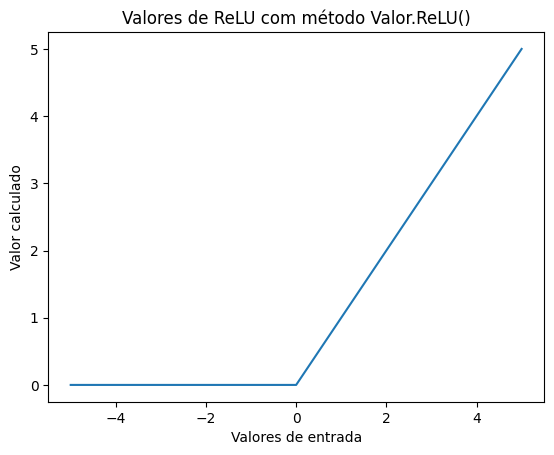

In [64]:
eixo = [i * 0.5 for i in range(-10,11)]
plt.plot(eixo, RELU_valores_method, label='Diferença do valores obtidos em diferentes métodos')
plt.xlabel('Valores de entrada')
plt.ylabel('Valor calculado')
plt.title('Valores de ReLU com método Valor.ReLU()')
plt.show()

In [65]:
Softplus_valores = [math.log(1 + math.exp(i * 0.5)) for i in range(-10, 11)]

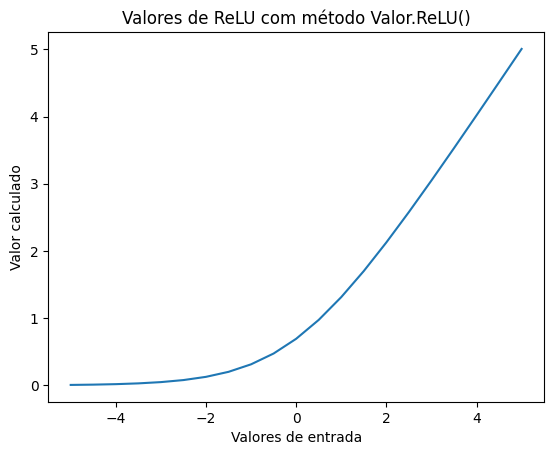

In [66]:
eixo = [i * 0.5 for i in range(-10,11)]
plt.plot(eixo, Softplus_valores, label='Diferença do valores obtidos em diferentes métodos')
plt.xlabel('Valores de entrada')
plt.ylabel('Valor calculado')
plt.title('Valores de ReLU com método Valor.ReLU()')
plt.show()

In [67]:
Softplus_valores_method = [Valor(i * 0.5).Softplus().data for i in range(-10, 11)]

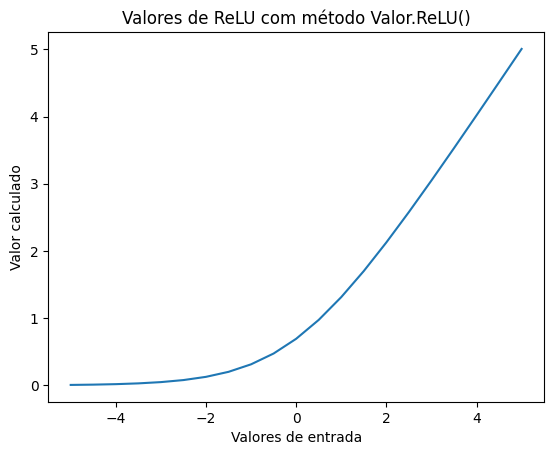

In [68]:
eixo = [i * 0.5 for i in range(-10,11)]
plt.plot(eixo, Softplus_valores_method, label='Diferença do valores obtidos em diferentes métodos')
plt.xlabel('Valores de entrada')
plt.ylabel('Valor calculado')
plt.title('Valores de ReLU com método Valor.ReLU()')
plt.show()

#### Grafos de exemplo:
Função tanh:

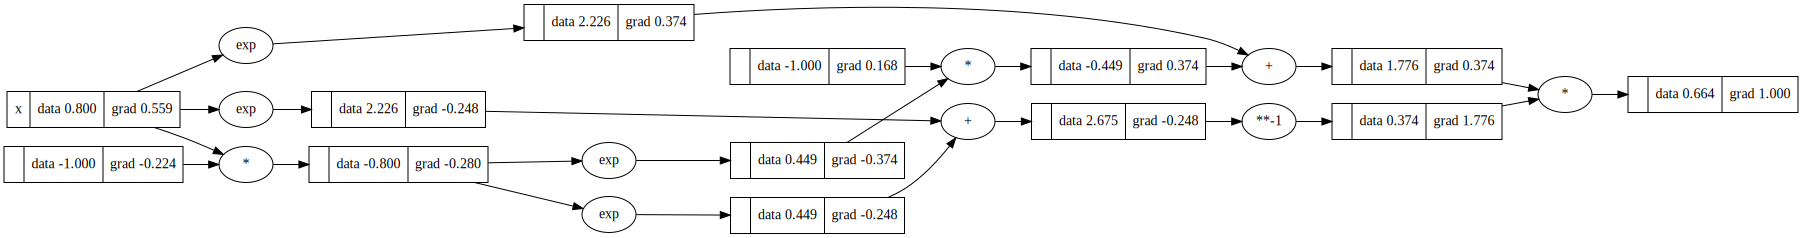

In [69]:
x = Valor(0.8, rotulo="x")
y = x.tanh()
y.propagar_tudo()
grafo = plota_grafo(y)
grafo.render("grafo_tanh", format="png")
grafo

Função ReLU:

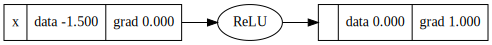

In [70]:
x = Valor(-1.5, rotulo="x")
y = x.ReLU()
y.propagar_tudo()
grafo = plota_grafo(y)
grafo.render("grafo_relu", format="png")
grafo

Função Softpus:

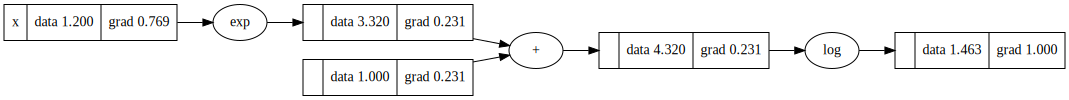

In [71]:
x = Valor(1.2, rotulo="x")
y = x.Softplus()
y.propagar_tudo()
grafo = plota_grafo(y)
grafo.render("grafo_softplus", format="png")
grafo


## Conclusão

Neste trabalho, implementamos três novas funções de ativação (tanh, ReLU e Softplus) em uma rede neural construída em Python puro, conforme solicitado no enunciado. Demonstramos o funcionamento dessas funções através de testes simples e gráficos, validando os resultados obtidos com resultados já conhecidos.

### Referências

- TIWARI, S. Activation functions in Neural Networks - GeeksforGeeks. 

Disponível em: <https://www.geeksforgeeks.org/activation-functions-neural-networks/>.

‌
- Classes da MLP em Python puro

 Obtidos em: ATP-303 NN 4.2 - Notebook MLP.ipynb